# NicheSphere differential co-localization tutorial

NicheSphere is an sc-verse compatible Python library which allows the user to find differentially co-localized cellular niches and biological processes involved in their interactions based on cell type pairs co-localization probabilities in different conditions. Cell type pair co-localization probabilities are obtained in different ways: from deconvoluted Visium 10x / PIC-seq data (probabilities of finding each cell type in each spot / multiplet), or counting cell boundaries overlaps for each cell type pair in single cell spatial data (MERFISH , CODEX ...). This tutorial focuses on defining groups of cells that converge or split in disease (Ischemia) based on differential co-localization. 

NicheSphere also offers the possibility to look at localized differential cell - cell communication based on Ligand-Receptor pairs expression data. This is addressed in the localized differential communication tutorial.


## 1. Libraries and functions

In [1]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import networkx as nx
import warnings
import scanpy as sc
import mudata as md
import numpy as np
from community_layout.layout_class import CommunityLayout
warnings.filterwarnings("ignore")

import nichesphere

COMMUNITY LAYOUT: Datashader not found, edge bundling not available


## 2. Data at first glance

In this example we will use data from the Myocardial Infarction atlas from Kuppe, C. et. Al., 2022

In [2]:
mudata=md.read('heart_MI_ST_SC_23samples.h5mu')
mudata

MuData object with n_obs × n_vars = 206792 × 39120
  2 modalities
    visium:	73904 x 11704
      obs:	'n_counts', 'n_genes', 'percent.mt', 'Adipocyte', 'Cardiomyocyte', 'Endothelial', 'Fibroblast', 'Lymphoid', 'Mast', 'Myeloid', 'Neuronal', 'Pericyte', 'Cycling.cells', 'vSMCs', 'cell_type_original', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'patient_region_id', 'orig_ident', 'batch'
      var:	'features'
      obsm:	'X_pca', 'X_spatial', 'X_umap'
    sc:	132888 x 27416
      obs:	'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'doublet_score', 'doublet', 'dissociation_s1', 'opt_clust', 'patient', 'batch', 'opt_clust_integrated', 'cell_type', 'ident', 'nFeaturess_RNA', 'cell_subtype', 'cell_subtype_available', 'cell_subtype2', 'patient_region_id', 'patient_group', 'sampleType'
      var:	'n_counts'
      obsm:	'X_harmony', 'X_pca', 'X_umap_harmony'

This is a subset with 23 samples (samples with less than 1500 cells in the snRNA-seq data were filtered out), and 33 different cell subtypes

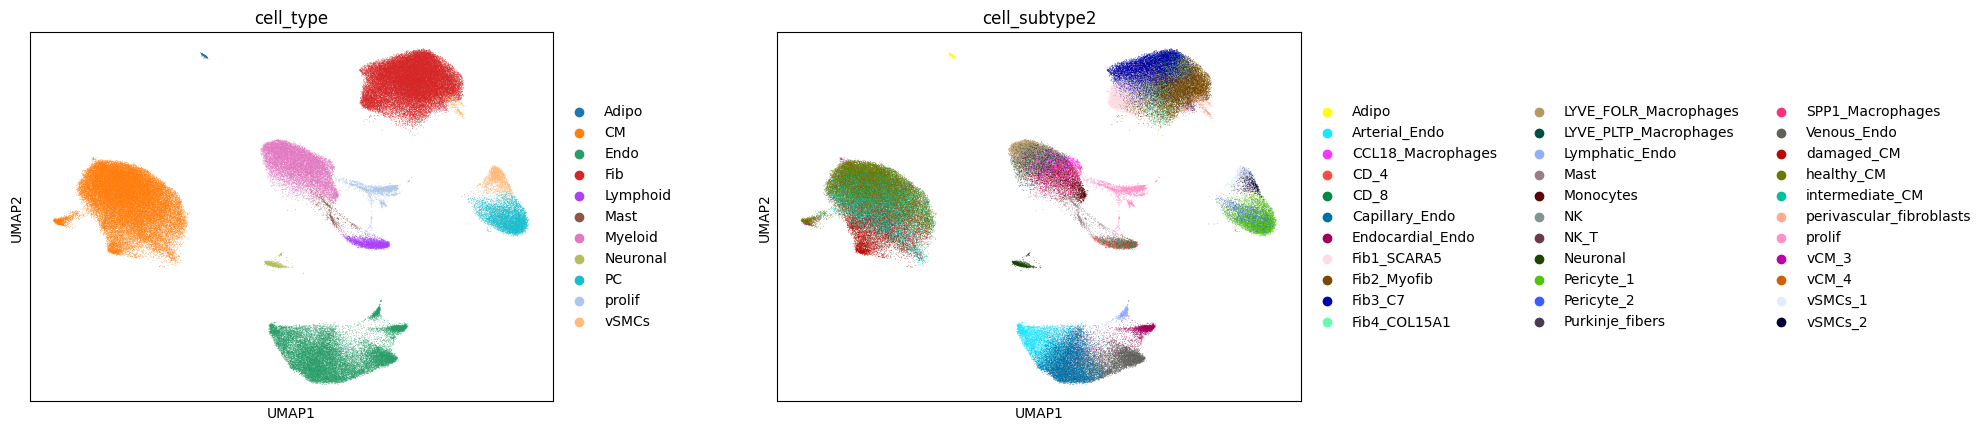

In [3]:
mudata['sc'].obsm['umap']=mudata['sc'].obsm['X_umap_harmony']
sc.pl.umap(mudata['sc'], 
           color=['cell_type', 'cell_subtype2'], wspace=0.3)

In this case, we will get cell type co-localization probabilities from **deconvoluted Visium** data (Cell type probabilities per spot): 

In a previous step, we used MOSCOT(Klein et. al., 2025) to deconvolute cell subtypes in visium slices from the same 23 samples , getting matrices of probabilities of each cell being in each spot. Then we got cell type probabilities per spot summing the probabilities of cells of the same kind in each spot; thus getting cell type probability matrices for all samples.

(you can have a closer look at these steps in the preprocessing tutorial)

In [4]:
CTprops=pd.read_csv('CTprops.csv', index_col=0)
CTprops.head()

,Fib1_SCARA5,damaged_CM,Capillary_Endo,LYVE_FOLR_Macrophages,Fib3_C7,healthy_CM,Fib2_Myofib,Endocardial_Endo,Arterial_Endo,Neuronal,...,CCL18_Macrophages,perivascular_fibroblasts,CD_4,vSMCs_2,Lymphatic_Endo,NK,CD_8,Purkinje_fibers,Adipo,NK_T
AAACAAGTATCTCCCA-1-1-0-0-0,0.000000e+00,0.000000e+00,0.0,8.333133e-16,0.000000,0.000000e+00,0.428865,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN,NaN
AAACAATCTACTAGCA-1-1-0-0-0,0.000000e+00,2.691729e-21,0.0,0.000000e+00,0.445912,5.540884e-01,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN,NaN
AAACACCAATAACTGC-1-1-0-0-0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000030,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.499508,0.0,0.0,NaN,NaN
AAACAGAGCGACTCCT-1-1-0-0-0,1.373226e-25,0.000000e+00,0.0,0.000000e+00,0.499762,3.111796e-13,0.500238,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN,NaN
AAACAGCTTTCAGAAG-1-1-0-0-0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.443230,0.113118,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,NaN,NaN


From these deconvolution results, we can look at **cell type proportions per sample**. For this we will need the spot ID and sample correspondence:

In [5]:
spotSamples=mudata['visium'].obs.patient_region_id
spotSamples.reset_index().head()

,index,patient_region_id
0,AAACAAGTATCTCCCA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...,control_P17
1,AAACACCAATAACTGC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...,control_P17
2,AAACAGCTTTCAGAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...,control_P17
3,AAACAGGGTCTATATT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...,control_P17
4,AAACCGGGTAGGTACC-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0...,control_P17


A way to check the deconvolution proportions is using a clustermap

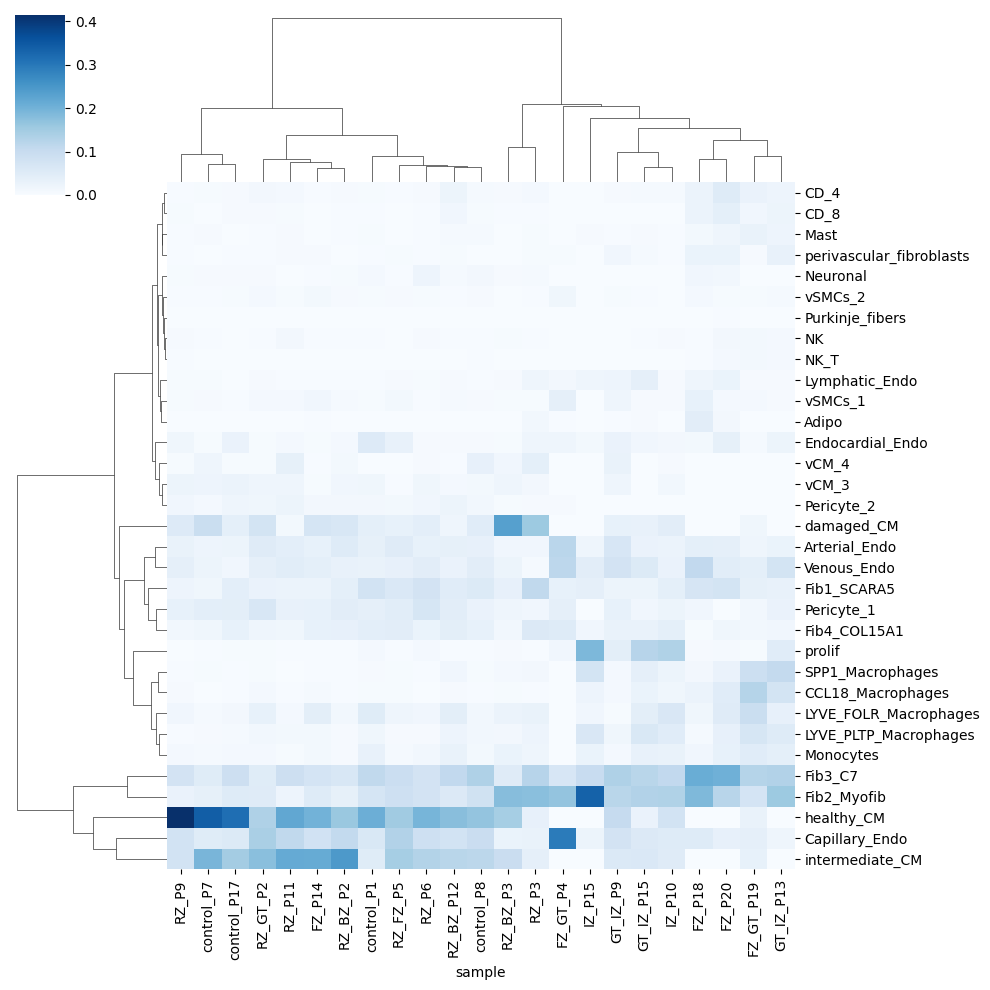

In [6]:
CTprops_sample=CTprops.copy()
CTprops_sample['sample']=mudata['visium'].obs.patient_region_id
sns.clustermap(CTprops_sample.groupby('sample').sum().T/CTprops_sample.groupby('sample').sum().sum(axis=1) , 
               cmap='Blues', method='ward')

Alternativelly, we can check the deconvolution proportions using barplots

In [7]:
t1=pd.DataFrame(CTprops[spotSamples=='control_P7'].sum(), columns=['control_P7'])
t2=pd.DataFrame(CTprops[spotSamples=='IZ_P15'].sum(), columns=['IZ_P15'])

Text(0.5, 1.0, 'IZ_P15')

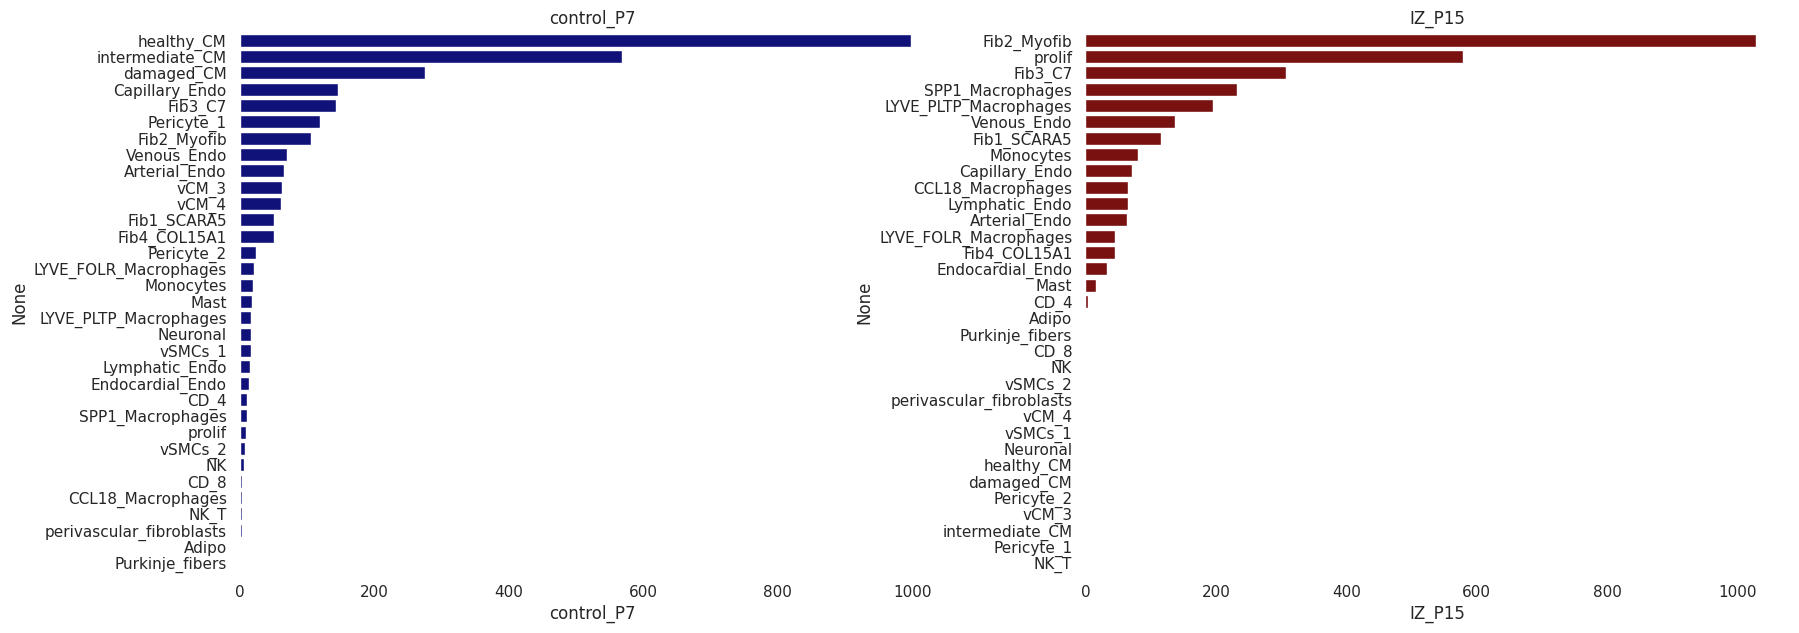

In [8]:
sns.set(font_scale=1)
sns.set_style(rc = {'axes.facecolor': 'white'})

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

sns.barplot(ax=axes[0], y=t1.sort_values('control_P7', ascending=False).index, x='control_P7', 
            data=t1.sort_values('control_P7', ascending=False), color='darkblue')
axes[0].set_title('control_P7')

sns.barplot(ax=axes[1], y=t2.sort_values('IZ_P15', ascending=False).index, x='IZ_P15',
            data=t2.sort_values('IZ_P15', ascending=False), color='darkred')
axes[1].set_title('IZ_P15')

We can visualize **cell type deconvolution results in slices** (spots are colored by the the cell type with highest proportion). For this we will need the spatial coordinates of the spots in the Visium slices need to be in the slot **uns['spatial']** of the Visium anndata object:

In [9]:
mudata['visium'].uns['spatial']=mudata['visium'].obsm['X_spatial']

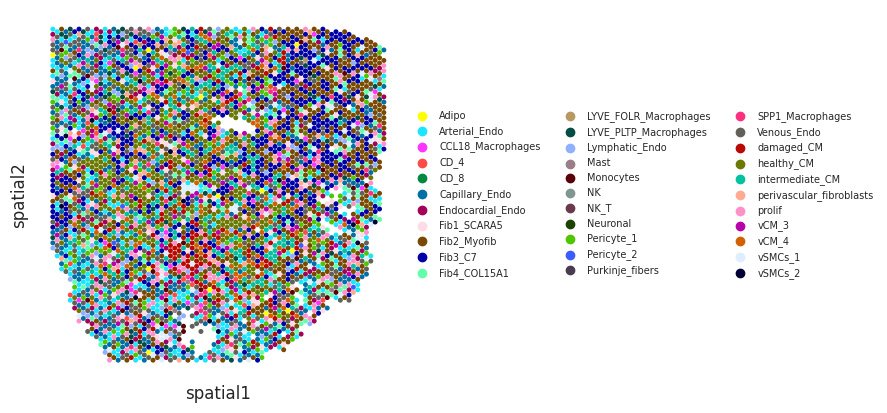

In [10]:
idPat = 'GT_IZ_P9'
nichesphere.coloc.spatialCTPlot(adata=mudata['visium'][mudata['visium'].obs.patient_region_id==idPat].copy(), 
                                CTprobs=CTprops.loc[spotSamples.index[spotSamples==idPat]], 
                                cell_types=mudata['sc'].obs.cell_subtype2, spot_size=0.015, 
                                legend_fontsize=7)

## 3. Co-localization

We computed then co-localization probabilities from the cell type probability matrices. Here we got concatenated co-localization sample matrices of cell type x cell type.

Then we reshaped the co-localization data into a matrix of cell type pairs x samples.

(you can have a closer look at these steps in the preprocessing tutorial)

In [11]:
colocPerSample=pd.read_csv('colocPerSample.csv', index_col=0)
colocPerSample.head()

,Fib1_SCARA5-Fib1_SCARA5,Fib1_SCARA5-damaged_CM,Fib1_SCARA5-Capillary_Endo,Fib1_SCARA5-LYVE_FOLR_Macrophages,Fib1_SCARA5-Fib3_C7,Fib1_SCARA5-healthy_CM,Fib1_SCARA5-Fib2_Myofib,Fib1_SCARA5-Endocardial_Endo,Fib1_SCARA5-Arterial_Endo,Fib1_SCARA5-Neuronal,...,NK_T-CCL18_Macrophages,NK_T-perivascular_fibroblasts,NK_T-CD_4,NK_T-vSMCs_2,NK_T-Lymphatic_Endo,NK_T-NK,NK_T-CD_8,NK_T-Purkinje_fibers,NK_T-Adipo,NK_T-NK_T
control_P17,0.017603,0.000308,0.000992,0.000251,0.007062,0.002586,0.004724,0.000943,0.000412,0.000351,...,2.290066e-15,0.0,3.915381e-05,0.0,0.0,4.538656e-08,4.556003e-08,0.0,0.000000e+00,0.000268
RZ_P9,0.009307,0.000429,0.000738,0.000003,0.005204,0.001439,0.001625,0.000065,0.000168,0.000046,...,0.000000e+00,0.0,4.640548e-05,0.0,0.0,9.954633e-05,1.643486e-05,0.0,0.000000e+00,0.000784
IZ_P15,0.030351,0.000000,0.000027,0.000186,0.001200,0.000000,0.003112,0.000072,0.000062,0.000000,...,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000
RZ_P6,0.040470,0.000441,0.002752,0.000361,0.008687,0.002928,0.007878,0.000176,0.001022,0.001170,...,0.000000e+00,0.0,7.998369e-25,0.0,0.0,8.593925e-28,0.000000e+00,0.0,0.000000e+00,0.000438
RZ_BZ_P3,0.021508,0.000292,0.000567,0.000057,0.002408,0.000483,0.006635,0.000123,0.000052,0.000052,...,0.000000e+00,0.0,0.000000e+00,0.0,0.0,8.585311e-06,0.000000e+00,0.0,7.294563e-35,0.000897


The sum of the probabilities of every cell type pair in a sample must be = 1

In [12]:
colocPerSample.sum(axis=1)

control_P17    1.0
RZ_P9          1.0
IZ_P15         1.0
RZ_P6          1.0
RZ_BZ_P3       1.0
FZ_P14         1.0
RZ_BZ_P12      1.0
FZ_GT_P4       1.0
GT_IZ_P13      1.0
GT_IZ_P15      1.0
FZ_P20         1.0
RZ_FZ_P5       1.0
GT_IZ_P9       1.0
RZ_P3          1.0
FZ_GT_P19      1.0
FZ_P18         1.0
IZ_P10         1.0
control_P7     1.0
RZ_P11         1.0
control_P1     1.0
RZ_BZ_P2       1.0
control_P8     1.0
RZ_GT_P2       1.0
dtype: float64

Same cell type interactions will be excluded later on, so we'll have a list of same cell type interaction pairs in order to subset the co-localization table we'll generate in the next step.

In [13]:
cell_types=CTprops.columns
oneCTints=cell_types+'-'+cell_types

**Conditions**

We will need the following metadata to subset the samples in **control (myogenic)** and **disease (ischemic)**:

In [14]:
sampleTypesDF=pd.read_csv('MI_sampleTypesDF.csv')
sampleTypesDF.head()

,Unnamed: 0,sample,sampleType
0,0,control_P17,myogenic
1,1,RZ_P9,remote
2,2,IZ_P15,ischemic
3,3,RZ_P6,remote
4,4,RZ_BZ_P3,border


## 4. Differential co-localization analysis

We will test differential co-localization between **myogenic** and **ischemic** samples using Wilcoxon rank sums tests:

**Null Hypothesis (H0):**
The median of the population of differences between co-localization probabilities of cell types a and b in myogenic and ischemic samples is zero.

**Alternative Hypothesis (H1):**
The median of the population of differences between co-localization probabilities of cell types a and b in myogenic and ischemic samples is not equal to zero.

In [15]:
myo_iscDF=nichesphere.coloc.diffColoc_test(coloc_pair_sample=colocPerSample, 
                                           sampleTypes=sampleTypesDF, 
                                           exp_condition='ischemic', 
                                           ctrl_condition='myogenic')
myo_iscDF.head()

,pairs,statistic,p-value
pairs,,,
Fib1_SCARA5-Fib1_SCARA5,Fib1_SCARA5-Fib1_SCARA5,0.489898,0.624206
Fib1_SCARA5-damaged_CM,Fib1_SCARA5-damaged_CM,-2.44949,0.014306
Fib1_SCARA5-Capillary_Endo,Fib1_SCARA5-Capillary_Endo,-2.204541,0.027486
Fib1_SCARA5-LYVE_FOLR_Macrophages,Fib1_SCARA5-LYVE_FOLR_Macrophages,-0.489898,0.624206
Fib1_SCARA5-Fib3_C7,Fib1_SCARA5-Fib3_C7,-2.44949,0.014306


Then we will reshape the data to visualize the Wilcoxon test scores in a heatmap and filter non significant co-localization differences using the parameter **p** (in this case, scores with p-values > 0.1 are filtered out)

In [16]:
myo_isc_HM=nichesphere.tl.pval_filtered_HMdf(testDF=myo_iscDF, 
                                             oneCTinteractions=oneCTints, 
                                             p=0.1,                             #threshold p-value to filter
                                             cell_types=cell_types)
myo_isc_HM.head()

,Fib1_SCARA5,damaged_CM,Capillary_Endo,LYVE_FOLR_Macrophages,Fib3_C7,healthy_CM,Fib2_Myofib,Endocardial_Endo,Arterial_Endo,Neuronal,...,CCL18_Macrophages,perivascular_fibroblasts,CD_4,vSMCs_2,Lymphatic_Endo,NK,CD_8,Purkinje_fibers,Adipo,NK_T
Fib1_SCARA5,0.000000,-2.449490,-2.204541,0.000000,-2.449490,-2.449490,-1.959592,0.000000,0.000000,-2.449490,...,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0,0,0.000000
damaged_CM,-2.449490,0.000000,-2.204541,-1.959592,-2.449490,-2.449490,-2.204541,-2.449490,-2.204541,-2.449490,...,0.000000,0.0,-2.44949,-1.959592,0.0,0.0,-2.204541,0,0,-1.837117
Capillary_Endo,-2.204541,-2.204541,0.000000,0.000000,-2.204541,-2.449490,0.000000,-2.204541,-2.449490,-2.449490,...,0.000000,0.0,-2.44949,0.000000,0.0,0.0,-2.449490,0,0,0.000000
LYVE_FOLR_Macrophages,0.000000,-1.959592,0.000000,0.000000,0.000000,-1.959592,0.000000,0.000000,0.000000,-1.837117,...,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0,0,0.000000
Fib3_C7,-2.449490,-2.449490,-2.204541,0.000000,0.000000,-2.449490,0.000000,0.000000,-1.714643,-2.449490,...,1.714643,0.0,0.00000,0.000000,0.0,0.0,0.000000,0,0,0.000000


As the cells classified as proliferating cells (prolif) are many different cell types and thus hard to interpret, we'll remove them for further analysis.

In [17]:
myo_isc_HM=myo_isc_HM.loc[myo_isc_HM.columns.str.contains('prolif')==False,myo_isc_HM.index.str.contains('prolif')==False]

We will also remove cells with no significant co-localization differences

In [18]:
myo_isc_HM=myo_isc_HM.loc[myo_isc_HM.sum()!=0,myo_isc_HM.sum()!=0]

Now we can plot the differential co-localization scores heatmap

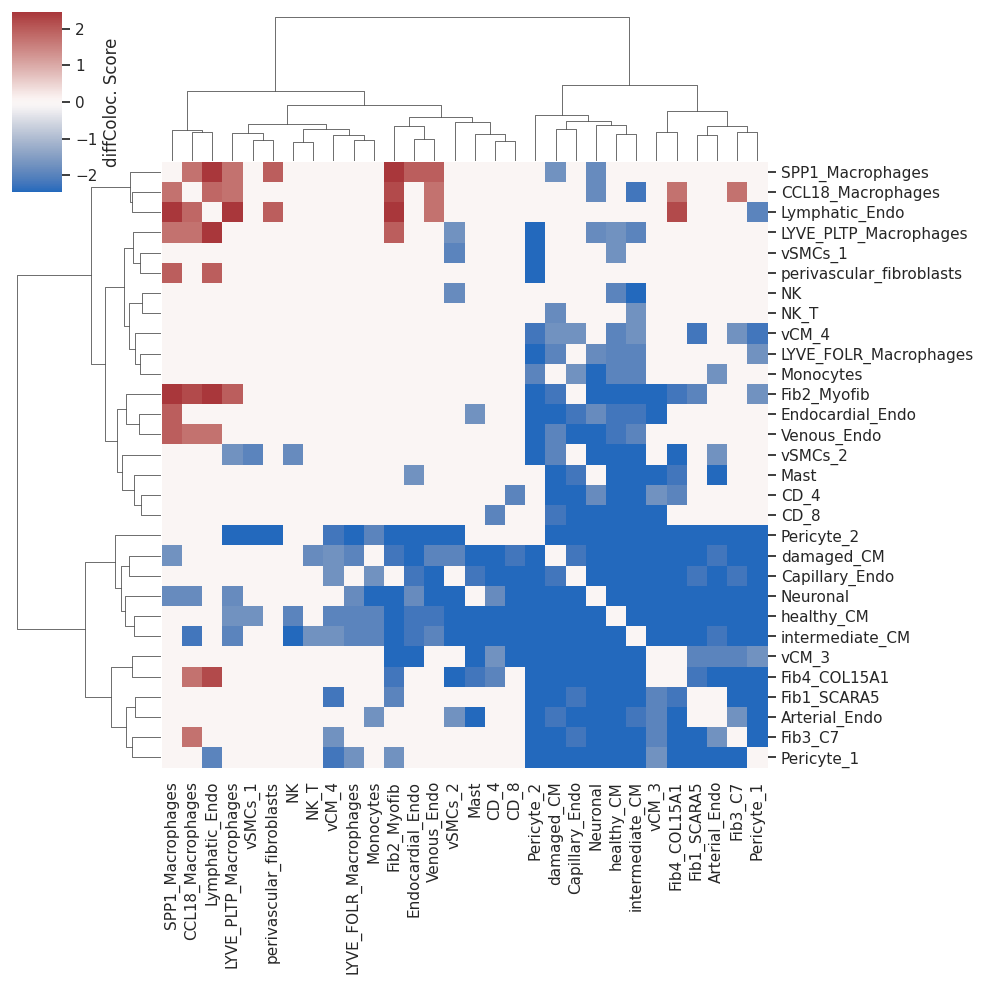

In [19]:
sns.set(font_scale=1)
plot=sns.clustermap(myo_isc_HM, cmap='vlag', center=0, method='ward', cbar_kws={'label': 'diffColoc. Score'})

**Differential co-localization network**

To build the differential co-localization network, we will get an **adjacency matrix** (adj) based on the **euclidean distances** among the distributions of significant differential co-localization scores for the different cell types

In [20]:
HMdist=pd.DataFrame(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(myo_isc_HM)), 
                    columns=myo_isc_HM.columns, index=myo_isc_HM.index)

HMsimm=1-HMdist/HMdist.max().max()
##Cell pairs with not significant differential co-localization get 0
HMsimm[myo_isc_HM==0]=0

A **cell group dictionary** should be used here to visualize different cell groups in different colors. As we don't have cell groups yet, we'll have a dictionary of all cells in one group and a list of one color

In [21]:
niches_dict={'1_': list(myo_isc_HM.index)}
clist=['#4daf4a']

Now we can plot the differential co-localization network using the **colocNW** function from NicheSphere. This function has many parameters that can be tuned: 

**nodeSize** for example, defines how the size of the nodes will be calculated. Options are 'betweeness', 'pagerank' (both network statistics) and None (all nodes have the same size).
**alpha** indicates the transparency of the edges and in goes from 0 (completely transparent) to 1 (opaque)
**fsize** is the size of the figure (x,y)

This function returns the network with the edge weights corresponding to the diff. coloc. scores (positive and negative)

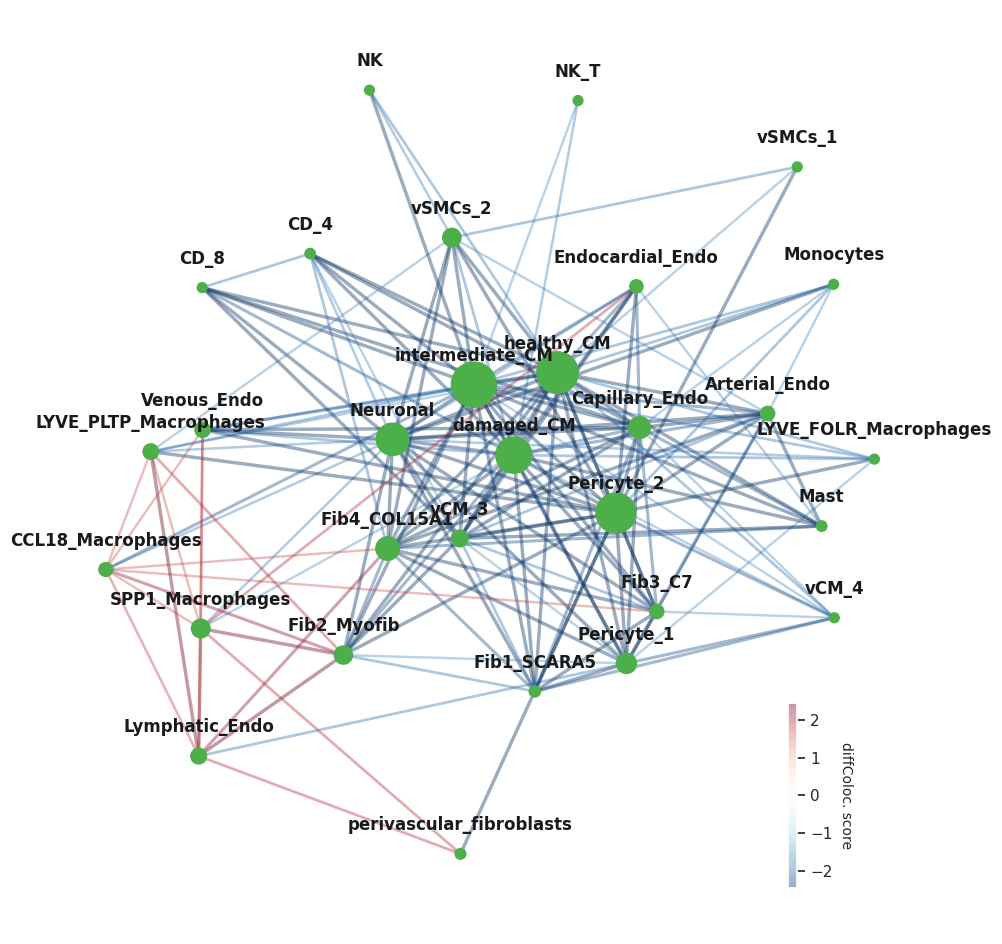

In [22]:
plt.rcParams['axes.facecolor'] = "None"
nichesphere.coloc.colocNW(x_diff=myo_isc_HM,            #differential co-localization matrix
                          adj=HMsimm,                   #adjacency matrix
                          cell_group=niches_dict, 
                          clist=clist, 
                          nodeSize='betweeness',        
                          lab_spacing=9,                #space between node and label
                          alpha=0.4,                    #edges transparency
                          fsize=(12,12))                #figure size

Now we'll do community detection using Louvain. First we will get the network from the adjacency matrix as we won't use the signed weights for this

In [23]:
gCol_unsigned=nx.from_pandas_adjacency(HMsimm, create_using=nx.Graph)

We will use the community-layout library function **CommunityLayout** to show the communities in a layout suited for this. This function is compatible with networkx (Hagberg et. al., 2008) community detection functions, which will be used internally as indicated by the parameters **community_algorithm** and **community_kwargs**

In [24]:
## Calculate community layout
cl=CommunityLayout(gCol_unsigned,
        community_compression = 0.4,
        layout_algorithm = nx.spring_layout,
        layout_kwargs = {"k":75, "iterations":1000},
        community_algorithm = nx.algorithms.community.louvain_communities,
        community_kwargs = {"resolution":1.1,  'seed':12, 'weight':'weight'})

Building meta-graph
Metagraph is a Graph with 4 nodes and 6 edges


100%|██████████| 4/4 [00:00<00:00, 250.61it/s]


We can extract the communities (niches) as follows:

In [25]:
d = {index: list(value) for index, value in enumerate(cl.communities())}
print(pd.DataFrame.from_dict(d, orient='index').T.to_string(index=False))

           0                     1             2                        3
 Fib1_SCARA5              Neuronal    healthy_CM perivascular_fibroblasts
  Pericyte_2       intermediate_CM Arterial_Endo        CCL18_Macrophages
       vCM_4                  CD_8       vSMCs_1           Lymphatic_Endo
  Pericyte_1                  NK_T            NK    LYVE_PLTP_Macrophages
Fib4_COL15A1        Capillary_Endo       vSMCs_2              Fib2_Myofib
     Fib3_C7      Endocardial_Endo     Monocytes         SPP1_Macrophages
        None                 vCM_3          None              Venous_Endo
        None LYVE_FOLR_Macrophages          None                     None
        None            damaged_CM          None                     None
        None                  Mast          None                     None
        None                  CD_4          None                     None


And then name them

In [26]:
niche_names=['1_Stromal', '2_Stressed_CM', '3_Healthy_CM', '4_Fibrotic']
niches_dict=dict(zip(niche_names,list(d.values()))) 
print(pd.DataFrame.from_dict(niches_dict, orient='index').T.to_string(index=False))

   1_Stromal         2_Stressed_CM  3_Healthy_CM               4_Fibrotic
 Fib1_SCARA5              Neuronal    healthy_CM perivascular_fibroblasts
  Pericyte_2       intermediate_CM Arterial_Endo        CCL18_Macrophages
       vCM_4                  CD_8       vSMCs_1           Lymphatic_Endo
  Pericyte_1                  NK_T            NK    LYVE_PLTP_Macrophages
Fib4_COL15A1        Capillary_Endo       vSMCs_2              Fib2_Myofib
     Fib3_C7      Endocardial_Endo     Monocytes         SPP1_Macrophages
        None                 vCM_3          None              Venous_Endo
        None LYVE_FOLR_Macrophages          None                     None
        None            damaged_CM          None                     None
        None                  Mast          None                     None
        None                  CD_4          None                     None


And assign them colors to color the network nodes according to their niche

In [27]:
clist=['#4daf4a', '#0072B5', '#BC3C29', '#ffff33']
niche_cols=pd.Series(clist, index=list(niches_dict.keys()))
niches_df=nichesphere.tl.cells_niche_colors(CTs=CTprops.columns, 
                                            niche_colors=niche_cols, 
                                            niche_dict=niches_dict)
niches_df.head()

,cell,niche,color
cell,,,
Fib1_SCARA5,Fib1_SCARA5,1_Stromal,#4daf4a
damaged_CM,damaged_CM,2_Stressed_CM,#0072B5
Capillary_Endo,Capillary_Endo,2_Stressed_CM,#0072B5
LYVE_FOLR_Macrophages,LYVE_FOLR_Macrophages,2_Stressed_CM,#0072B5
Fib3_C7,Fib3_C7,1_Stromal,#4daf4a


Then we can get the node positions to input them to the NicheSphere **colocNW** function through the **pos** parameter

In [28]:
pos=cl.full_positions

And plot the niches on the community layout

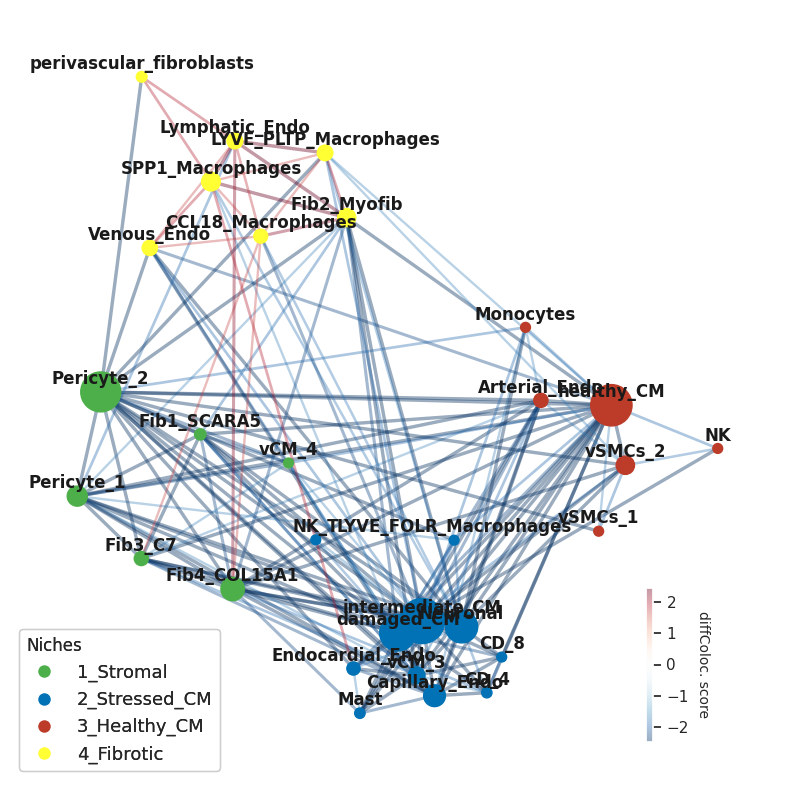

In [29]:
plt.rcParams['axes.facecolor'] = "None"

gCol=nichesphere.coloc.colocNW(x_diff=myo_isc_HM, 
                               adj=HMsimm,
                               cell_group=niches_dict, 
                               clist=clist, 
                               nodeSize='betweeness', 
                               layout=None,                         #layout needs to be set to None if we provide node positions
                               lab_spacing=0.05, 
                               thr=1, 
                               alpha=0.4, 
                               fsize=(10,10), 
                               pos=pos,                             #node positions (from the CommunityLayout function)
                               edge_scale=1,                        #edge width
                               legend_ax=[0.7, 0.05, 0.15, 0.2])    #legend position
#Legend
legend_elements1=[plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=clist[i], lw=4, 
                             label=list(niches_dict.keys())[i], ms=10) for i in range(len(list(niches_dict.keys())))]
plt.gca().add_artist(plt.legend(handles=legend_elements1,loc='lower left', fontsize=13, title='Niches', 
                                alignment='left'))
#plt.savefig('diffColocNW_CD.pdf')

We can also calculate some network statistics with the networkx package functions (this will be done on the signed network):

In [30]:
t1=pd.DataFrame({'betweenness':[nx.betweenness_centrality(gCol)[x] for x in list(gCol.nodes)], 
                 'degree':[nx.degree_centrality(gCol)[x] for x in list(gCol.nodes)], 
                 'pagerank':[nx.pagerank(gCol, weight=None)[x] for x in list(gCol.nodes)]})
t1.index=list(gCol.nodes)

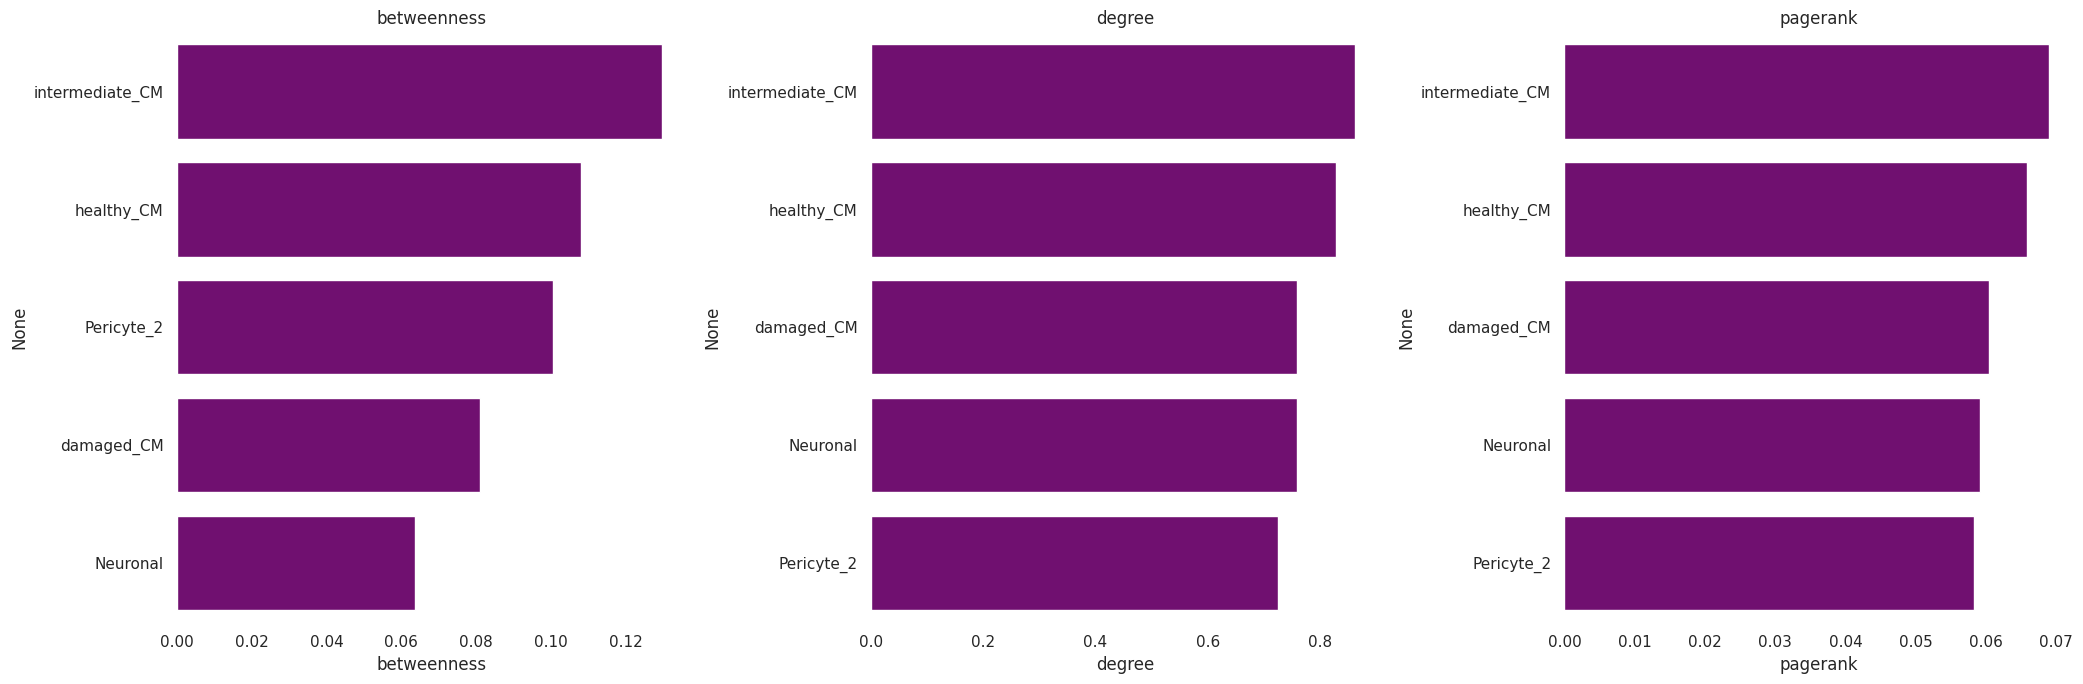

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
for i in range(len(t1.columns)):
    _ = sns.barplot(ax=axes[i], y=t1.sort_values(t1.columns[i], ascending=False).index[0:5], x=t1.columns[i], 
        data=t1.sort_values(t1.columns[i], ascending=False)[0:5], color='purple')
    axes[i].set_title(t1.columns[i])
fig.tight_layout()

So we can look separately at positive and negative degree:

In [32]:
## Positive edges stats
G_pos=gCol.copy()
to_remove=[(a,b) for a, b, attrs in G_pos.edges(data=True) if attrs["weight"] <= 0]
G_pos.remove_edges_from(to_remove)

t1=pd.DataFrame({'degree':[nx.degree_centrality(G_pos)[x] for x in list(G_pos.nodes)]})
t1.index=list(G_pos.nodes)

In [33]:
## Negative edges stats
G_neg=gCol.copy()
to_remove=[(a,b) for a, b, attrs in G_neg.edges(data=True) if attrs["weight"] >= 0]
G_neg.remove_edges_from(to_remove)

t2=pd.DataFrame({'degree':[nx.degree_centrality(G_neg)[x] for x in list(G_neg.nodes)]})
t2.index=list(G_neg.nodes)

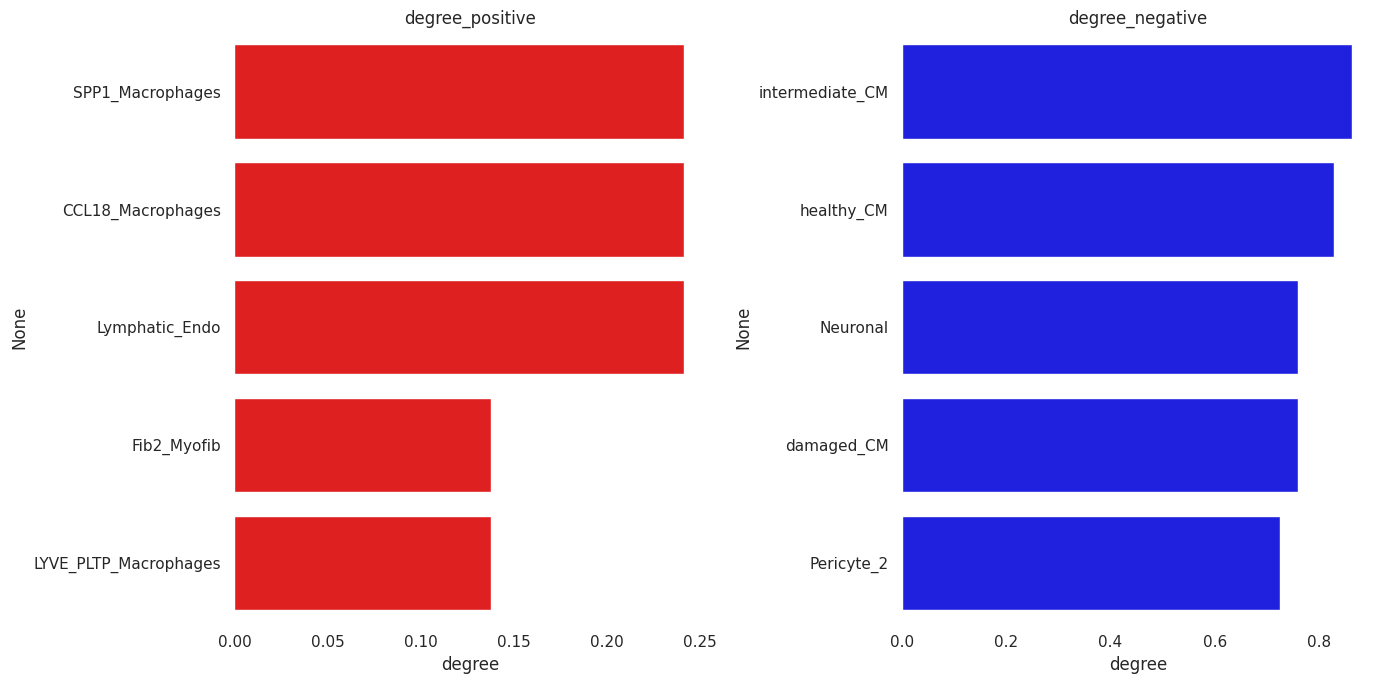

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

_=sns.barplot(ax=axes[0], y=t1.sort_values('degree', ascending=False).index[0:5], x='degree', 
              data=t1.sort_values('degree', ascending=False)[0:5], color='red')
axes[0].set_title('degree_positive')

_=sns.barplot(ax=axes[1], y=t2.sort_values('degree', ascending=False).index[0:5], x='degree', 
              data=t2.sort_values('degree', ascending=False)[0:5], color='blue')
axes[1].set_title('degree_negative')

fig.tight_layout()

And also visualize niches in slices (spots are colored by the niche to which the cell type with highest proportion belongs)

**Niche plots**

Now we will visualize the **niches** in the **slices** coloring the Visium spots according to the niche of the cell type with the highest proportion. 

These are a couple **myogenic** slices, which will be at the **top** panels of the next figure:

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(21, 7))
plt.close(fig)
for idu,smpl in enumerate(list(sampleTypesDF['sample'][sampleTypesDF['sampleType']=='myogenic'][0:3])):  
    _ = nichesphere.coloc.spatialNichePlot(adata=mudata['visium'][mudata['visium'].obs.patient_region_id==smpl].copy(), 
                                       CTprobs=CTprops.loc[spotSamples.index[spotSamples==smpl]],    #dataframe of cell type probabilities per spot
                                       niche_dict=niches_dict,
                                       spot_size=0.015, 
                                       niche_colors=niche_cols,                                      #series of colors with niche names as indexes
                                       legend_fontsize=7, save_name='_'+smpl+'.pdf',ax=axes[0][idu])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

And a couple **ischemic** slices, which will be at the **bottom** panels of the next figure:

In [36]:
for idu,smpl in enumerate(list(sampleTypesDF['sample'][sampleTypesDF['sampleType']=='ischemic'][0:3])):  
    _ = nichesphere.coloc.spatialNichePlot(adata=mudata['visium'][mudata['visium'].obs.patient_region_id==smpl].copy(), 
                                       CTprobs=CTprops.loc[spotSamples.index[spotSamples==smpl]], 
                                       niche_dict=niches_dict,
                                       spot_size=0.015, 
                                       niche_colors=niche_cols, 
                                       legend_fontsize=7, 
                                       save_name='_'+smpl+'.pdf',ax=axes[1][idu])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

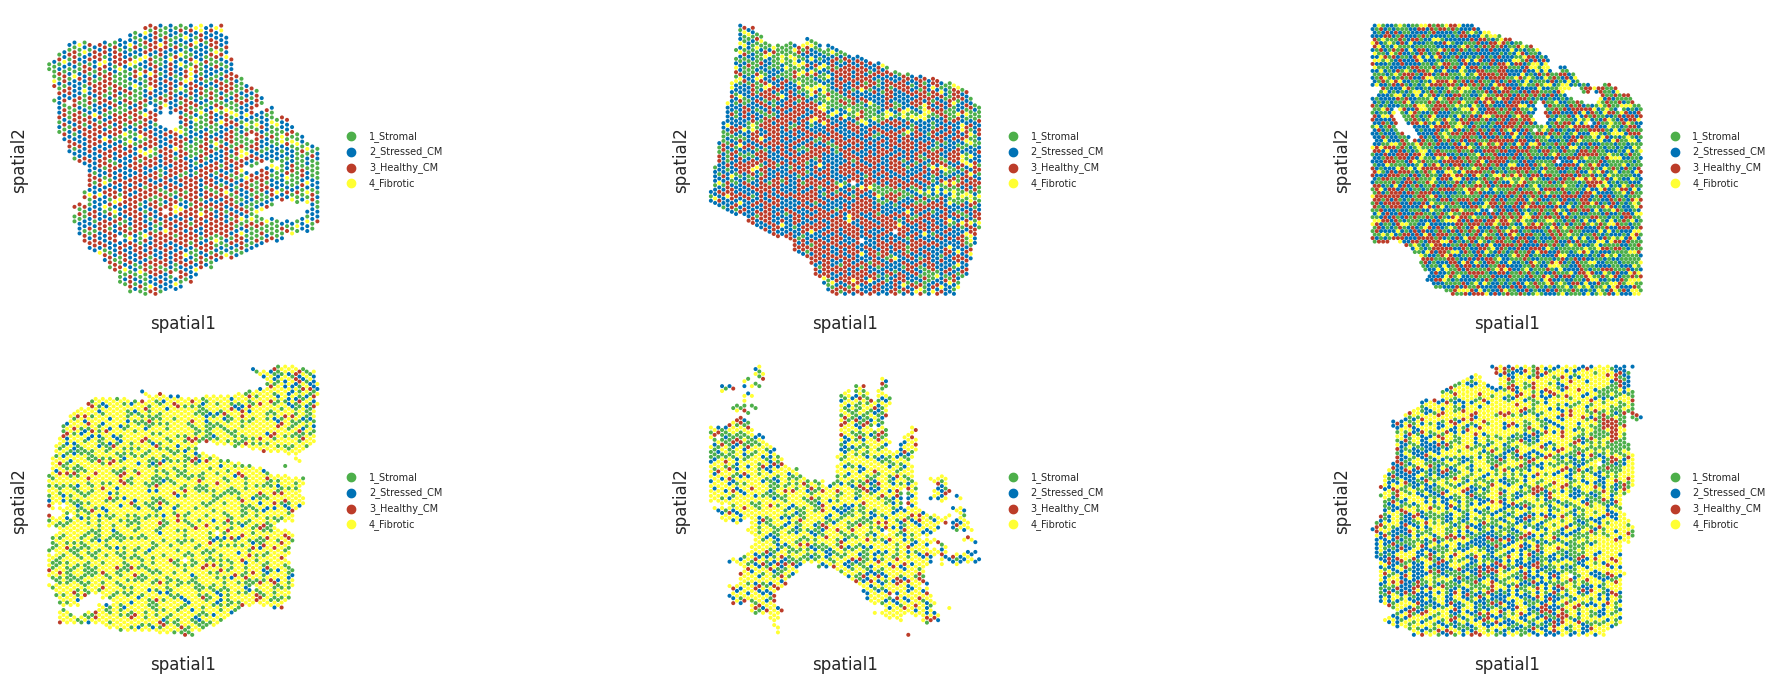

In [37]:
fig.tight_layout()
fig

For further analysis, like differential communication: https://nichesphere.readthedocs.io/en/latest/tutorials.html 

, we will need the correspondence data between cell pairs and niche pairs

In [38]:
pairCatDFdir=nichesphere.tl.get_pairCatDFdir(niches_df)
pairCatDFdir.to_csv('pairCatDFdir_MIvisium_louvain.csv')
pairCatDFdir.head()

,cell_pairs,niche_pairs
0,Fib1_SCARA5->Fib1_SCARA5,1_Stromal->1_Stromal
1,Fib1_SCARA5->damaged_CM,1_Stromal->2_Stressed_CM
2,Fib1_SCARA5->Capillary_Endo,1_Stromal->2_Stressed_CM
3,Fib1_SCARA5->LYVE_FOLR_Macrophages,1_Stromal->2_Stressed_CM
4,Fib1_SCARA5->Fib3_C7,1_Stromal->1_Stromal


We will also need a filtering object **(colocFilt)** indicating which cell pairs are differentially co-localized to filter the communication data

In [39]:
## Get data of cells present in the adjacency matrix
pairCatDF_filter=[(pairCatDFdir.cell_pairs.str.split('->')[i][0] in HMsimm.index)&
                  (pairCatDFdir.cell_pairs.str.split('->')[i][1] in HMsimm.index) for i in pairCatDFdir.index]
pairCatDFdir_filt=pairCatDFdir[pairCatDF_filter]
oneCTints_filt=oneCTints[[i.split('-')[0] in HMsimm.index for i in oneCTints]]

In [40]:
## Get data to flag differentially co-localized cell pairs in the adjacency matrix
colocFilt=nichesphere.tl.getColocFilter(pairCatDF=pairCatDFdir_filt, 
                                        adj=HMsimm, 
                                        oneCTints=oneCTints_filt.str.replace('-', '->'))
colocFilt.to_csv('colocFilt_MIvisium_louvain.csv')
colocFilt.head()

,filter
cell_pairs,
Fib1_SCARA5->Fib1_SCARA5,1.0
Fib1_SCARA5->damaged_CM,1.0
Fib1_SCARA5->Capillary_Endo,1.0
Fib1_SCARA5->LYVE_FOLR_Macrophages,0.0
Fib1_SCARA5->Fib3_C7,1.0


We will need the niche - cell type - color correspondence data, the co-localization network and nodes positions for further analysis as well

In [41]:
niches_df.to_csv('niches_df_MIvisium_louvain.csv')
nx.write_graphml_lxml(gCol, "colocNW_MIvisium_louvain.graphml")
np.save('colocNW_pos.npy', pos)